# Introduction to Domain Adaptation and Optimal Transport

## Domain Adaptation: Definition and problem

**Domain Adaptation** is a major problem in Machine Learning, where the goal is to adapt a model trained on a source domain to a target domain, usually presenting differences in distribution. In most cases, models are trained on a specific dataset and may face poor performance when applied to a new dataset with different characteristics. Domain Adaptation aims to solve this problem by reducing the gap between these two domains and thus improving the model's performance on the target domain.

The main challenge of Domain Adaptation is to deal with the differences in distribution between the source and target domains. These differences may be due to variations in the examples' features, selection biases, or differences in observation conditions. When these differences are significant, models trained on the source domain may have poor performance on the target domain, making it difficult to use them in real-world applications.

## Optimal Transport: a solution for Domain Adaptation

In the paper "Optimal Transport for Domain Adaptation" by Aude Genevay, Gabriel Peyré, and Marco Cuturi, the authors propose using **Optimal Transport** theory to solve the Domain Adaptation problem. Optimal Transport is a mathematical method that determines the optimal way to transfer a probability distribution to another, minimizing a given transport cost.

The authors show that Optimal Transport can be used to align the source and target domain distributions by determining a transformation that minimizes the distance between these two domains. This transformation can then be applied to the source domain examples to adapt them to the target domain, thereby improving the model's performance.

## Objective of the Notebook

In this notebook, we will first recontextualize the Domain Adaptation problem and present a concrete example to illustrate its impact on Machine Learning models. Then, we will use the `ott-Jax` package to implement an Optimal Transport-based solution, building on the research paper mentioned earlier. We will show that Optimal Transport effectively solves the fitting issues induced by Domain Adaptation and thus improves the model's performance on the target domain.

## Mathematical Development

In their paper, the authors suggest that the domain adaptation problem can be seen as a graph matching problem. The use of optimal transport for this problem is based on the hypothesis that the domain drift is due to a transformation $T : \mathcal{X}^{source} \rightarrow \mathcal{X}^{target}$. This transformation can be interpreted as the push forward or transport map of $\mu$ to $\nu$, i.e., $T\#\mu = \nu$.

We can then derive a procedure to solve the adaptation problem:
1. Estimate $\mu$ and $\nu$ with the datasets
2. Estimate the transport map $T$ as defined above
3. Train a classifier on the transported source sample $T(\mathcal{X}^{source})$

As finding T from all possible transformations is intractable, we will introduce a cost function and solve the Monge or Kantorovitch problem. The Monge problem seeks to find a deterministic transport map that minimizes the cost function, while the Kantorovitch problem seeks to find a probabilistic transport plan.

The Kantorovitch formulation is more tractable and can be expressed as a linear optimization problem:

$$
\Pi^* = \arg\min_{\Pi \in \mathcal{U}(\mu, \nu)} \langle \Pi, C \rangle_F
$$

where $\Pi^*$ is the optimal transport plan, $\mathcal{U}(\mu, \nu)$ is the set of transport plans with marginals $\mu$ and $\nu$, $C$ is the cost matrix, and $\langle \cdot, \cdot \rangle$

## Our tool problem : 

Let's introduce a sim

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pylab as plt
from ott.geometry import pointcloud,costs
from ott.solvers.linear import sinkhorn
import ot.plot

In [37]:
n_source_samples = 100
n_target_samples = 100
theta = 2 * np.pi / 20
noise_level = 0.2

x_s, y_s = ot.datasets.make_data_classif(
    'gaussrot', n_source_samples, nz=noise_level)
x_t, y_t = ot.datasets.make_data_classif(
    'gaussrot', n_target_samples, theta=theta, nz=noise_level)

# one of the target mode changes its variance (no linear mapping)
x_t[y_t == 2] *= 3
x_t = x_t + 3

In [3]:
def classification_otda_data_maker(n_s,n_t,noise,n_s_out,n_t_out,power_out) :
    """
    This function will create a simply dataset with a source sample and a target sample with features and labels
    
    Theses arguments is the degree of complexity of the domain drift and the number of outliers respectly
    
    Args : 
        n
        noise 
        
    return x_s,y_s,x_t,y_t
    
    """
    # Source sample
    rot = np.array(
        [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    m1 = np.array([-1, 1])
    m2 = np.array([1, -1])
    y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
    n1 = np.sum(y == 1)
    n2 = np.sum(y == 2)
    x = np.zeros((n, 2))
    def 
    if np.isscalar(sigma):
            sigma = np.array([sigma, ])
    if len(sigma) > 1:
        P = sp.linalg.sqrtm(sigma)
        res = generator.randn(n, 2).dot(P) + m
    else:
        res = generator.randn(n, 2) * np.sqrt(sigma) + m
    x[y == 1, :] = make_2D_samples_gauss(n1, m1, nz, random_state=generator)
    x[y == 2, :] = make_2D_samples_gauss(n2, m2, nz, random_state=generator)

    x = x.dot(rot)
    
    for out in range(n_s_out): 
        row_sampled = np.random.choice(x_s.shape[0])
        x_s[row_sampled] = np.multiply(x_s[row_sampled], power_out) 


    #Target Sample
    y_t = np.floor((np.arange(n_t) * 1.0 / n_t * 3)) + 1
    x_t = np.zeros((n_t, 2))

    x_t[y_t == 1, 0] = -1.
    x_t[y_t == 1, 1] = -1.
    x_t[y_t == 2, 0] = -1.
    x_t[y_t == 2, 1] = 1.
    x_t[y_t == 3, 0] = 1.
    x_t[y_t == 3, 1] = 0
    x_t[y_t != 3, :] += 5 * noise * np.random.randn(sum(y_t != 3), 2)
    x_t[y_t == 3, :] += 2 * noise * np.random.randn(sum(y_t == 3), 2)
    
    for out in range(n_t_out): 
        row_sampled = np.random.choice(x_t.shape[0])
        x_t[row_sampled] = np.multiply(x_t[row_sampled], power_out) 
    
    return x_s,y_s,x_t,y_t


x_s,y_s,x_t,y_t = classification_otda_data_maker(100,100,0.5,1,1,5)

Text(0.5, 1.0, 'Target samples')

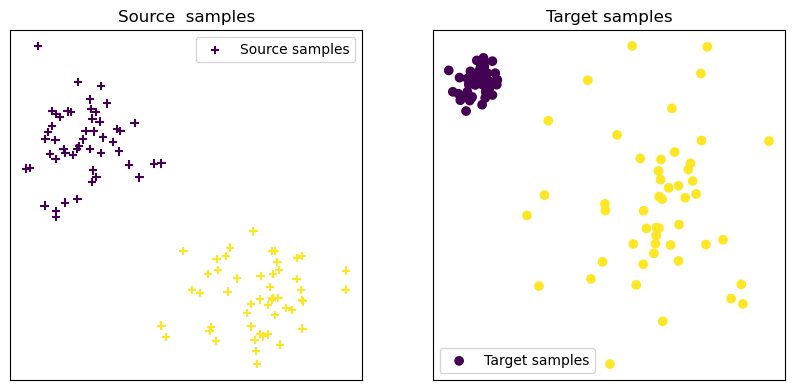

In [25]:
plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title('Source  samples')

plt.subplot(2, 2, 2)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title('Target samples')

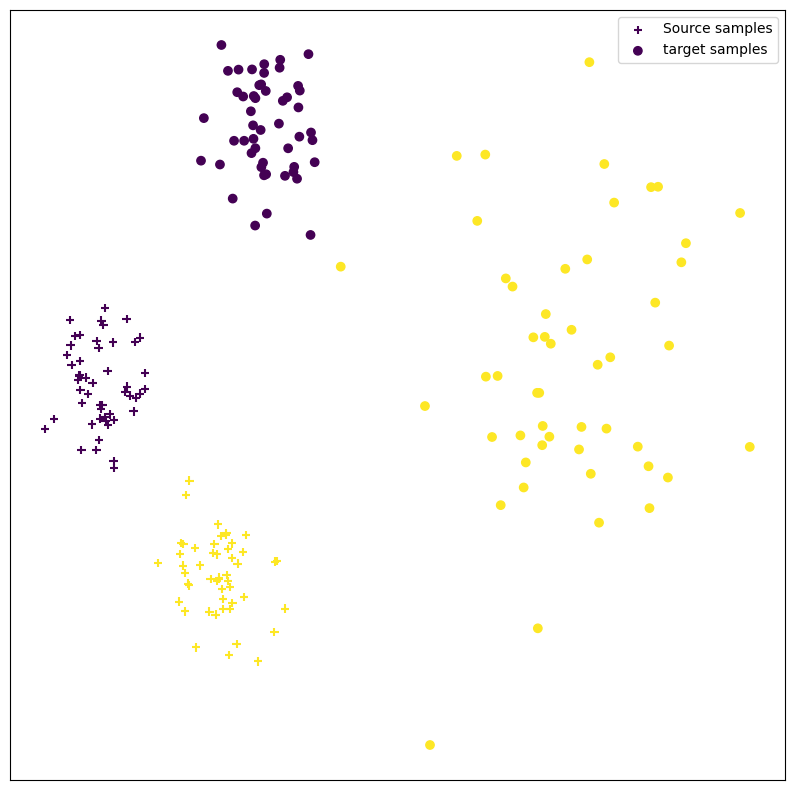

In [38]:
plt.figure(1, figsize=(10, 10))
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='target samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)


In [106]:
# Make the classifier : 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc_model_s = SVC(kernel='linear', random_state=32)
svc_model_s.fit(x_s, y_s)

# Constructing a hyperplane using a formula.
w_s = svc_model_s.coef_[0]           # w consists of 2 elements
b_s = svc_model_s.intercept_[0]      # b consists of 1 element
x_points_s = np.linspace(-2, 3)    # generat_ing x-points from -1 to 1
y_points_s = -(w_s[0] / w_s[1]) * x_points_s - b_s / w_s[1]  # getting 

prediction_xt = svc_model_s.predict(x_t)
accuracy = accuracy_score(y_t, prediction_xt)

print("Accuracy:", accuracy)

Accuracy: 0.9


In [107]:
svc_model_t = SVC(kernel='linear', random_state=32)
svc_model_t.fit(x_t, y_t)

# Constructing a hyperplane using a formula.
w_t = svc_model_t.coef_[0]           # w consists of 2 elements
b_t = svc_model_t.intercept_[0]      # b consists of 1 element
x_points_t = np.linspace(1.5, 4.5)    # generating x-points from -1 to 1
y_points_t = -(w_t[0] / w_t[1]) * x_points_t - b_t / w_t[1]  # getting 

prediction_xt = svc_model_t.predict(x_t)
accuracy = accuracy_score(y_t, prediction_xt)

print("Accuracy:", accuracy)

Accuracy: 0.99


In [88]:
x_all = np.concatenate((x_s, x_t), axis=0)
y_all = np.concatenate((y_s, y_t), axis=0)

In [108]:
svc_model_all = SVC(kernel='linear', random_state=32)
svc_model_all.fit(x_all, y_all)

# Constructing a hyperplane using a formula.
w_all = svc_model_all.coef_[0]           # w consists of 2 elements
b_all = svc_model_all.intercept_[0]      # b consists of 1 element
x_points_all = np.linspace(-2, 4.5)    # generating x-points from -1 to 1
y_points_all = -(w_all[0] / w_all[1]) * x_points_all - b_all / w_all[1]  # getting 


prediction_xt = svc_model_all.predict(x_t)
accuracy = accuracy_score(y_t, prediction_xt)

print("Accuracy:", accuracy)

Accuracy: 1.0


([], [])

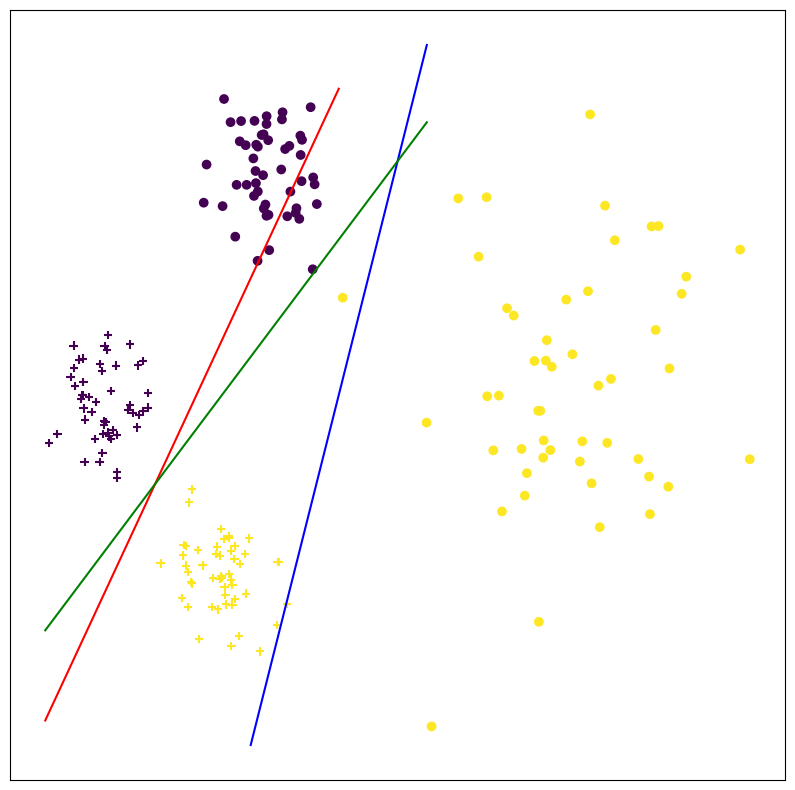

In [90]:
plt.figure(1, figsize=(10, 10))
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='target samples')
plt.plot(x_points_s, y_points_s, c='r')
plt.plot(x_points_t, y_points_t, c='b')
plt.plot(x_points_all, y_points_all, c='g')
plt.xticks([])
plt.yticks([])

In [91]:
import ot
# Cost matrix
M = ot.dist(x_s, x_t, metric='sqeuclidean')
M

array([[19.77919727, 19.05683042, 19.48179506, ..., 48.65243653,
        88.48570218, 47.45525799],
       [22.23085932, 20.22598312, 21.24915295, ..., 57.44951269,
        97.88426983, 54.78268469],
       [19.91425977, 19.01067679, 19.51873721, ..., 49.70938039,
        89.49011924, 48.24896587],
       ...,
       [23.75368556, 27.61194928, 25.95310542, ..., 29.03042497,
        71.79002476, 35.13318332],
       [25.62732267, 30.37425353, 28.31006331, ..., 26.34525087,
        69.56904243, 33.82239365],
       [21.12446556, 24.84855384, 23.23038742, ..., 27.45256802,
        68.16768306, 32.54986095]])

In [110]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=x_s, Xt=x_t)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=x_s, Xt=x_t)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=x_s, ys=y_s, Xt=x_t)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=x_s)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=x_s)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=x_s)

([], [])

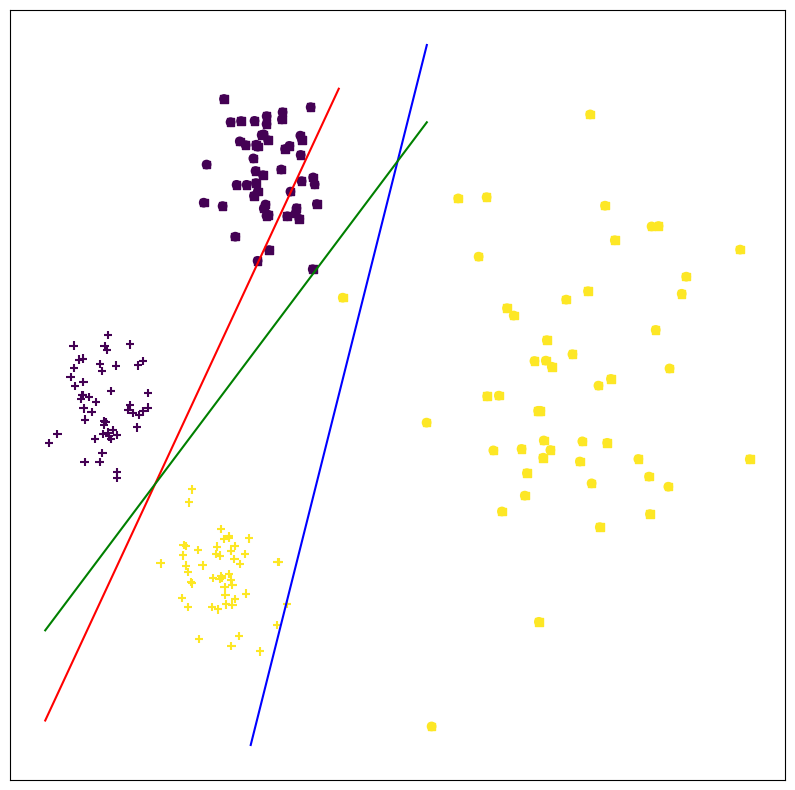

In [113]:

plt.figure(1, figsize=(10, 10))
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='target samples')
plt.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=y_s,
           marker='s', label='Transp samples', s=30)

plt.plot(x_points_s, y_points_s, c='r')
plt.plot(x_points_t, y_points_t, c='b')
plt.plot(x_points_all, y_points_all, c='g')
plt.xticks([])
plt.yticks([])

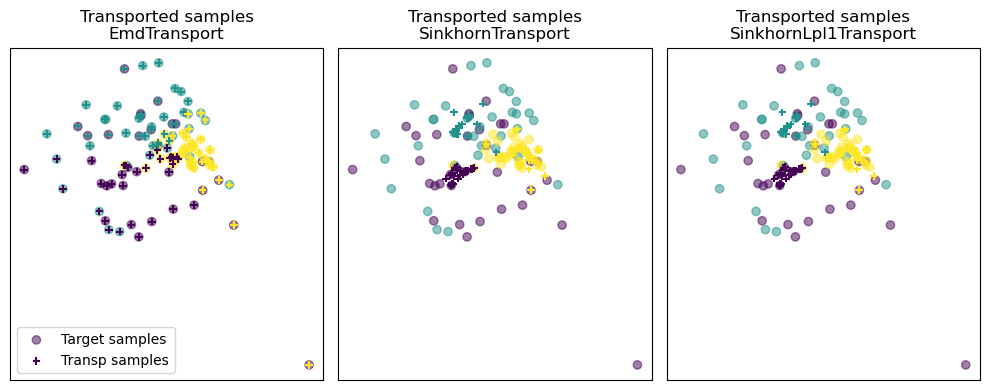

In [104]:
# display transported samples
plt.figure(4, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nEmdTransport')
plt.legend(loc=0)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nSinkhornTransport')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o',
           label='Target samples', alpha=0.5)
plt.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=y_s,
           marker='+', label='Transp samples', s=30)
plt.title('Transported samples\nSinkhornLpl1Transport')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

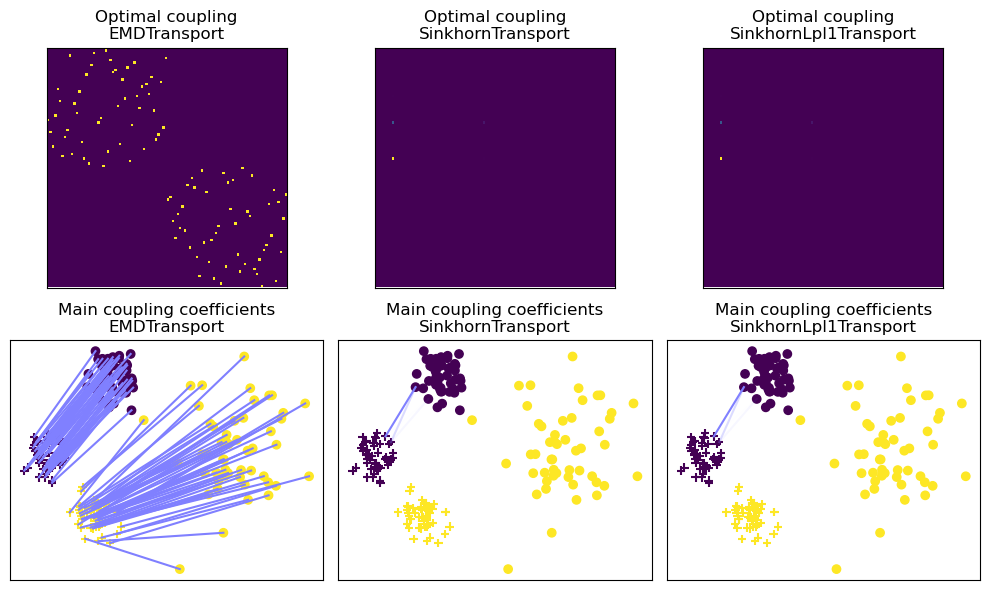

In [112]:
plt.figure(2, figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(ot_emd.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nEMDTransport')

plt.subplot(2, 3, 2)
plt.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nSinkhornTransport')

plt.subplot(2, 3, 3)
plt.imshow(ot_lpl1.coupling_, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Optimal coupling\nSinkhornLpl1Transport')

plt.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_emd.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nEMDTransport')

plt.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_sinkhorn.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nSinkhornTransport')

plt.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(x_s, x_t, ot_lpl1.coupling_, c=[.5, .5, 1])
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker='+', label='Source samples')
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker='o', label='Target samples')
plt.xticks([])
plt.yticks([])
plt.title('Main coupling coefficients\nSinkhornLpl1Transport')
plt.tight_layout()

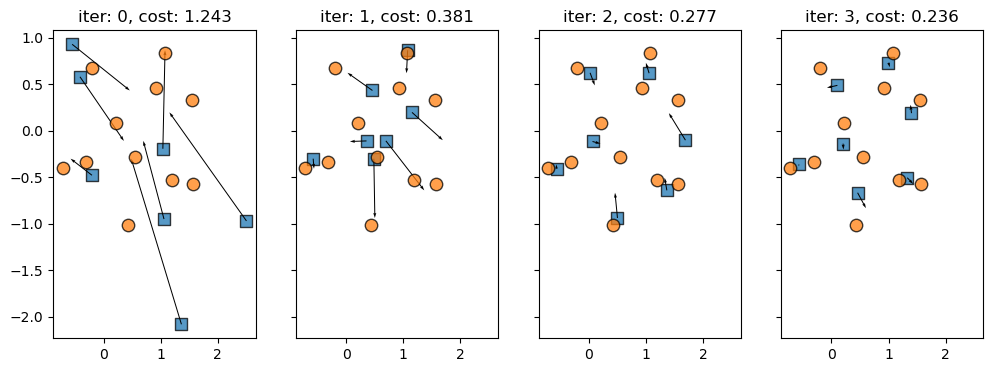

In [21]:
step = 5.0
x = x_old
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.005}
f, axes = plt.subplots(1, int(step-1), sharey=True, sharex=True, figsize=(12, 4))

for iteration, ax in enumerate(axes):
    cost, grad_x = r_ot(x, y)
    ax.scatter(x[:, 0], x[:, 1], **x_args)
    ax.quiver(
        x[:, 0],
        x[:, 1],
        -step * grad_x[:, 0],
        -step * grad_x[:, 1],
        **quiv_args,
    )
    ax.scatter(y[:, 0], y[:, 1], **y_args)
    ax.set_title(f"iter: {iteration}, cost: {cost:.3f}")
    x -= step * grad_x

In [22]:
cost

DeviceArray(0.23560537, dtype=float32)